In [1]:
import numpy as np
from scipy.stats import uniform
from matplotlib import pyplot as plt
from scipy.linalg import sqrtm

In [2]:
import time
import tqdm

In [3]:
import os

os.environ["OMP_NUM_THREADS"] = "1"

In [4]:
import pip

In [5]:
import multiprocessing
from multiprocessing import Pool

In [6]:
import copy

In [7]:
import getdist
from getdist import plots, MCSamples

In [5]:
# !pip install "git+https://github.com/cosmodesi/cosmoprimo#egg=cosmoprimo[class,camb,astropy,extras]"

Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: git+https://github.com/cosmodesi/cosmoprimo#egg=cosmoprimo[class,camb,astropy,extras] contains an egg fragment with a non-PEP 508 name. pip 25.1 will enforce this behaviour change. A possible replacement is to use the req @ url syntax, and remove the egg fragment. Discussion can be found at https://github.com/pypa/pip/issues/13157
  Cloning https://github.com/cosmodesi/cosmoprimo to /tmp/pip-install-pfh5vaa4/cosmoprimo_a934c5f268554fb088fc663f2729ef7f
  Running command git clone --filter=blob:none --quiet https://github.com/cosmodesi/cosmoprimo /tmp/pip-install-pfh5vaa4/cosmoprimo_a934c5f268554fb088fc663f2729ef7f
  Resolved https://github.com/cosmodesi/cosmoprimo to commit 51297754e337d7c6ddcb8dc09680d5974d887934
  Installing build dependencies ... one
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/adematti/pyclass to /tm

In [8]:
from cosmoprimo.fiducial import Planck2018FullFlatLCDM
from cosmoprimo.fiducial import DESI
from cosmoprimo import *
desi = DESI(engine='camb')
planck = Planck2018FullFlatLCDM(engine='camb')
from cosmoprimo import constants

In [7]:
# !git clone https://github.com/CobayaSampler/bao_data

fatal: destination path 'bao_data' already exists and is not an empty directory.


In [8]:
# data={}
# data['desi']=np.array([13.6200308 , 20.98334647])
# data['sdss']=np.array([13.36595, 22.31656])

In [9]:
# cov={}
# cov['desi']=np.array([[ 0.06346622, -0.06853373],  # 2-array with components being 2-arrays -> corresponds to the 2 theoretical parameters we are constraining (the1, the2)
#                       [-0.06853373,  0.37296876]])
# cov['sdss']=np.array([[ 0.04147534, -0.04873962],
#                       [-0.04873962,  0.3268589 ]])

In [10]:
# data['desi']=np.array([16.84645313, 20.07872919])  #datapoints in tension
# cov['desi']=np.array([[ 0.10197571, -0.07994031],
#        [-0.07994031,  0.35444916]])
# data['sdss']=np.array([17.85823692, 19.32575373])
# cov['sdss']=np.array([[ 0.1076634 , -0.0583182 ],
#        [-0.0583182 ,  0.28381764]])

In [9]:
alpha_desi_z=np.loadtxt('bao_data/desi_2024_gaussian_bao_ALL_GCcomb_mean.txt',usecols=[0,1]) #,z,alpha

In [10]:
alpha_desi_z_eff = np.array([0.295,0.51,0.706,0.93,1.317,1.491,2.33])

In [11]:
covariance_desi=np.loadtxt('bao_data/desi_2024_gaussian_bao_ALL_GCcomb_cov.txt')

In [12]:
covariance_sdss_DR12_LRG=np.loadtxt('bao_data/sdss_DR12_LRG_BAO_DMDH_covtot.txt')[2:4,2:4]
alpha_sdss_z_DR12_LRG=np.loadtxt('bao_data/sdss_DR12_LRG_BAO_DMDH.dat',usecols=[0,1])[2:4] #z=0.51

In [13]:
covariance_sdss_DR16_LRG=np.loadtxt('bao_data/sdss_DR16_LRG_BAO_DMDH_covtot.txt')
alpha_sdss_z_DR16_LRG=np.loadtxt('bao_data/sdss_DR16_LRG_BAO_DMDH.dat',usecols=[0,1]) #z=0.698\approx 0.706

In [14]:
c_l_ms = 299792458
c_l_kms = 299792458/1000

In [19]:
cosmo=Cosmology(w0_fld=-0.8,wa_fld=-1.5,Omega_m=0.3,h=0.68)
cosmo.set_engine('camb')


In [20]:
print(cosmo.comoving_angular_distance(0.5)/cosmo.rs_drag) #D_m/r_d
print(c_l_kms/(cosmo.efunc(0.5)*100)/cosmo.rs_drag) #D_H/r_d

13.136998901334497
23.21967002906061


In [16]:
def covariance(cov, R):
    a=np.zeros((4,4))
    a[0:2, 0:2]=cov["desi"]
    a[2:4,0:2]=R*np.dot(sqrtm(cov["desi"]),sqrtm(cov["sdss"]))
    a[0:2,2:4]=R*np.dot(sqrtm(cov["sdss"]),sqrtm(cov["desi"]))
    a[2:4,2:4]=cov["sdss"]
    return a
# cov_all=covariance(cov, 0.2)
# print(covariance(cov,1))

In [15]:
def log_like(the, obs, cov):
  delta=the-obs
  invcov=np.linalg.inv(cov)
  sign, logabsdet = np.linalg.slogdet(cov)
  if sign <= 0:
    return -np.inf
  # print(delta)
  # print(invcov)
  # print(logabsdet)
  # print(-0.5*np.dot(delta, np.dot(invcov, delta))-0.5*logabsdet)
  return -0.5*np.dot(delta, np.dot(invcov, delta))-0.5*logabsdet
  # print(the,obs, cov)
  #return -0.5*(delta**2/cov + np.log(cov))

In [18]:
def loglike_comb(theory, obs, cov): #combined loglike with an added systematic error in cov
  the1, the2, sigma_s = theory # the1, the2 are parallel and vertical components of alpha =D/r_s (without dividing by the fiducial alpha)
  if the1 < 12 or the1 > 20: # priors or bounds come from the initial data
    return -np.inf
  if the2 < 15 or the2 > 25:
    return -np.inf
  if sigma_s < 0 or sigma_s > 10:
    return -np.inf
  # print(the1)
  # print(the2)
  # print(sigma_s)
  # print(log_like(np.array([the1, the2]), obs['desi'], cov['desi']*(1 + sigma_s)) + log_like(np.array([the1, the2]), obs['sdss'], cov['sdss']*(1 + sigma_s)))
  return log_like(np.array([the1, the2, the1, the2]), np.concatenate((obs['desi'], obs["sdss"])), cov*(1 + sigma_s))

In [17]:
# !pip install emcee corner
import emcee
import corner

In [16]:
def cosmology(w0,wa,Omega_m,omega_b,h,z):
  cosmo=Cosmology(w0_fld=w0,wa_fld=wa,Omega_m=Omega_m,omega_b=omega_b, h=h)
  cosmo.set_engine('camb')
  a_p=cosmo.comoving_angular_distance(z)/cosmo.rs_drag #D_m/r_d
  a_v=c_l_kms/(cosmo.efunc(z)*100)/cosmo.rs_drag #D_H/r_d
  return a_p,a_v

In [21]:
cosmology(0.8,-1.5,0.3,0.005,0.7,[0.1,0.2,0.3])

(array([2.30817625, 4.18965514, 5.76321644]),
 array([20.70632961, 17.1170369 , 14.48304074]))

In [22]:
cosmo=Cosmology(w0_fld=-1,wa_fld=1,Omega_m=0.3,omega_b=0.02, h=0.7)
cosmo.set_engine('camb')

In [29]:
cosmo.Omega0_b

array(0.04081633)

In [18]:
def cosmology_iso(w0,wa,Omega_m,omega_b,h,z):
  cosmo=Cosmology(w0_fld=w0,wa_fld=wa,Omega_m=Omega_m,omega_b=omega_b, h=h)
  cosmo.set_engine('camb')
  d_m=cosmo.comoving_angular_distance(z) #D_m
  d_h=c_l_kms/(cosmo.efunc(z)*100) #D_H
  D_iso = (d_h*d_m**2*z)**(1/3)
  a_iso=D_iso/cosmo.rs_drag
  return a_iso

In [42]:
def cosmology_cmb(w0,wa,Omega_m,omega_b,h):
  cosmo=Cosmology(w0_fld=w0,wa_fld=wa,Omega_m=Omega_m,omega_b=omega_b, h=h)
  cosmo.set_engine('camb')
  theta_star=cosmo.theta_star
  omega_bc=(omega_b+cosmo.Omega0_cdm*h**2)
  return [theta_star,omega_b,omega_bc]

In [19]:
R_12=0.35 #z=0.51
R_16=0.21 #z=0.698
cov_combine = np.zeros((len(covariance_desi)+4,len(covariance_desi)+4))
cov_combine[0:len(covariance_desi),0:len(covariance_desi)]=copy.deepcopy(covariance_desi)

#DR12,z=0.51
cov_combine[len(covariance_desi):len(covariance_desi)+2,len(covariance_desi):len(covariance_desi)+2]=copy.deepcopy(covariance_sdss_DR12_LRG)
cov_combine[len(covariance_desi):len(covariance_desi)+2,1:3]=R_12*np.dot(sqrtm(covariance_sdss_DR12_LRG),sqrtm(covariance_desi[1:3,1:3]))
cov_combine[1:3,len(covariance_desi):len(covariance_desi)+2]=R_12*np.dot(sqrtm(covariance_sdss_DR12_LRG),sqrtm(covariance_desi[1:3,1:3])).T

#DR16,z=0.698
cov_combine[len(covariance_desi)+2:len(covariance_desi)+4,len(covariance_desi)+2:len(covariance_desi)+4]=copy.deepcopy(covariance_sdss_DR16_LRG)
cov_combine[len(covariance_desi)+2:len(covariance_desi)+4,3:5]=R_16*np.dot(sqrtm(covariance_sdss_DR16_LRG),sqrtm(covariance_desi[3:5,3:5]))
cov_combine[3:5,len(covariance_desi)+2:len(covariance_desi)+4]=R_16*np.dot(sqrtm(covariance_sdss_DR16_LRG),sqrtm(covariance_desi[3:5,3:5])).T

In [51]:
order= ['thetastar', 'ombh2', 'ombch2']
global means_cmb
means_cmb = np.array([0.01041027, 0.02223208, 0.14207901])
global covs_cmb
covs_cmb=np.array([[ 6.62099420e-12,  1.24442058e-10, -1.19287532e-09], [ 1.24442058e-10,  2.13441666e-08, -9.40008323e-08], [-1.19287532e-09, -9.40008323e-08,  1.48841714e-06]])

In [52]:
def loglike_cosmo(theory, obs, cov, z): #cosmological parameters, only desi
  w0, wa, h, Omega_m, omega_b, sigma_s = theory
  if Omega_m <0.01 or Omega_m>0.99:
    return -np.inf
  if omega_b <0.005 or omega_b>0.1:
    return -np.inf
  if h >1 or h<0.2:
    return -np.inf
  if w0<-3 or w0>1:
    return -np.inf
  if wa<-3 or wa>2:
    return -np.inf
  if sigma_s < 0 or sigma_s > 10:
    return -np.inf
  if w0+wa>0:
    return -np.inf
  alpha_p,alpha_v=cosmology(w0,wa,Omega_m,omega_b,h,[z[1],z[2],z[3],z[4],z[6]])
  alpha_iso=cosmology_iso(w0,wa,Omega_m,omega_b,h,[z[0],z[5]])
  alpha_combine=np.array([alpha_iso[0],alpha_p[0],alpha_v[0],alpha_p[1],alpha_v[1],alpha_p[2],alpha_v[2],alpha_p[3],alpha_v[3],alpha_iso[1],alpha_p[4],alpha_v[4],alpha_p[0],alpha_v[0],alpha_p[1],alpha_v[1]])
    # z[1]=0.51, z[2]=0.698, we have to do it twice
    
  cmb_vector=cosmology_cmb(w0,wa,Omega_m,omega_b,h)-means_cmb
  invcov=np.linalg.inv(covs_cmb)
  log_like_cmb = -0.5*np.dot(cmb_vector, np.dot(invcov, cmb_vector))
  #return log_like(alpha_combine, obs, cov*(1 + sigma_s))-((omega_b-0.02218)**2/0.00055**2)*0.5+log_like_cmb
  return log_like(alpha_combine, obs, cov*(1 + sigma_s))+log_like_cmb

In [54]:
# Initialize in a ball around some nominal value, sigmas<10
with Pool() as pool:
  sampler = emcee.EnsembleSampler(nwalkers, ndim, loglike_cosmo,pool=pool,args=[np.concatenate((alpha_desi_z.T[1],alpha_sdss_z_DR12_LRG.T[1],alpha_sdss_z_DR16_LRG.T[1])),cov_combine,alpha_desi_z_eff])
  p0 = emcee.utils.sample_ball(np.array([-1, 0, 0.7, 0.3, 0.02, 0.1]), np.array([0.1, 0.1, 0.1, 0.01, 0.001, 0.1]), size=nwalkers)
  # Run the sampler... this will take about 15 seconds for 500 steps.
  start = time.time()
  pos, prob, state = sampler.run_mcmc(p0, 5000, progress=True)
  end = time.time()
  multi_time = end - start
  print("Multiprocessing took {0:.1f} seconds".format(multi_time))
  # Throw away the first 50 samples

chain_cmb = sampler.flatchain[500:,:]

  2%|█▍                                                                               | 87/5000 [00:20<19:08,  4.28it/s]


KeyboardInterrupt: 

In [37]:
def loglike_cosmo_desi(theory, obs, cov, z): #cosmological parameters, only desi
  w0, wa, h, Omega_m, omega_b, sigma_s = theory
  if Omega_m <omega_b/h**2 or Omega_m>0.99:
    return -np.inf
  if omega_b <0.005 or omega_b>0.1:
    return -np.inf
  if h >1 or h<0.2:
    return -np.inf
  if w0<-3 or w0>1:
    return -np.inf
  if wa<-3 or wa>2:
    return -np.inf
  if sigma_s < 0 or sigma_s > 10:
    return -np.inf
  if w0+wa>0:
    return -np.inf
  alpha_p,alpha_v=cosmology(w0,wa,Omega_m,omega_b,h,[z[1],z[2],z[3],z[4],z[6]])
  alpha_iso=cosmology_iso(w0,wa,Omega_m,omega_b,h,[z[0],z[5]])
  alpha_combine=np.array([alpha_iso[0],alpha_p[0],alpha_v[0],alpha_p[1],alpha_v[1],alpha_p[2],alpha_v[2],alpha_p[3],alpha_v[3],alpha_iso[1],alpha_p[4],alpha_v[4]])
  return log_like(alpha_combine, obs, cov*(1 + sigma_s))-((omega_b-0.02218)**2/0.00055**2)*0.5

In [ ]:
# Initialize in a ball around some nominal value, sigmas=0
with Pool() as pool:
  sampler = emcee.EnsembleSampler(nwalkers, ndim, loglike_cosmo_desi,pool=pool,args=[(alpha_desi_z.T[1]),covariance_desi,alpha_desi_z_eff])
  p0 = emcee.utils.sample_ball(np.array([-1, 0, 0.7, 0.3, 0.02, 1.0]), np.array([0.1, 0.1, 0.1, 0.01, 0.001, 0.5]), size=nwalkers)
  # Run the sampler... this will take about 15 seconds for 500 steps.
  start = time.time()
  pos, prob, state = sampler.run_mcmc(p0, 5000, progress=True)
  end = time.time()
  multi_time = end - start
  print("Multiprocessing took {0:.1f} seconds".format(multi_time))
  # Throw away the first 50 samples

chain_desi = sampler.flatchain[500:,:]

In [23]:
nwalkers = 20
ndim = 6

In [27]:
# Initialize in a ball around some nominal value, sigmas=0
with Pool() as pool:
  sampler = emcee.EnsembleSampler(nwalkers, ndim, loglike_cosmo,pool=pool,args=[np.concatenate((alpha_desi_z.T[1],alpha_sdss_z_DR12_LRG.T[1],alpha_sdss_z_DR16_LRG.T[1])),cov_combine,alpha_desi_z_eff])
  p0 = emcee.utils.sample_ball(np.array([-1, 0, 0.7, 0.3, 0.02, 0.1]), np.array([0.1, 0.1, 0.1, 0.01, 0.001, 0.1]), size=nwalkers)
  # Run the sampler... this will take about 15 seconds for 500 steps.
  start = time.time()
  pos, prob, state = sampler.run_mcmc(p0, 5000, progress=True)
  end = time.time()
  multi_time = end - start
  print("Multiprocessing took {0:.1f} seconds".format(multi_time))
  # Throw away the first 50 samples

chain2 = sampler.flatchain[500:,:]

/home/shjsfz/.local/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|███████████████████████████████████████████████████████████████████████████████| 5000/5000 [11:58<00:00,  6.96it/s]


Multiprocessing took 718.6 seconds


In [28]:
np.save("MC_sigmas0_10_5000.npy", chain)  # Save in NumPy binary format
np.savetxt("MC_sigmas0_10_5000.txt", chain)  # Save as a text file

In [ ]:
# Initialize in a ball around some nominal value, sigmas=0
with Pool() as pool:
  sampler = emcee.EnsembleSampler(nwalkers, ndim, loglike_cosmo,pool=pool,args=[np.concatenate((alpha_desi_z.T[1],alpha_sdss_z_DR12_LRG.T[1],alpha_sdss_z_DR16_LRG.T[1])),cov_combine,alpha_desi_z_eff])
  p0 = emcee.utils.sample_ball(np.array([-1, 0, 0.7, 0.3, 0.02, 0.001]), np.array([0.1, 0.1, 0.1, 0.01, 0.001, 0.0001]), size=nwalkers)
  # Run the sampler... this will take about 15 seconds for 500 steps.
  start = time.time()
  pos, prob, state = sampler.run_mcmc(p0, 5000, progress=True)
  end = time.time()
  multi_time = end - start
  print("Multiprocessing took {0:.1f} seconds".format(multi_time))
  # Throw away the first 50 samples

chain = sampler.flatchain[500:,:]

In [ ]:
np.save("MC_sigmas0_5000.npy", chain)  # Save in NumPy binary format
np.savetxt("MC_sigmas0_5000.txt", chain)  # Save as a text file

In [24]:
# Initialize in a ball around some nominal value, sigmas!=0
with Pool() as pool:
  nwalkers = 20
  ndim = 6
  sampler1 = emcee.EnsembleSampler(nwalkers, ndim, loglike_cosmo,pool=pool,args=[np.concatenate((alpha_desi_z.T[1],alpha_sdss_z_DR12_LRG.T[1],alpha_sdss_z_DR16_LRG.T[1])),cov_combine,alpha_desi_z_eff])
  p1 = emcee.utils.sample_ball(np.array([-1, 0, 0.7, 0.3, 0.02, 0.01]), np.array([0.1, 0.1, 0.1, 0.01, 0.001, 0.01]), size=nwalkers)
  # Run the sampler... this will take about 15 seconds for 500 steps.
  start = time.time()
  pos, prob, state = sampler1.run_mcmc(p1, 5000, progress=True)
  end = time.time()
  multi_time = end - start
  print("Multiprocessing took {0:.1f} seconds".format(multi_time))
  # Throw away the first 50 samples

chain1 = sampler1.flatchain[500:,:]

100%|███████████████████████████████████████████████████████████████████████████████| 5000/5000 [09:45<00:00,  8.53it/s]


Multiprocessing took 585.9 seconds


In [25]:
np.save("MC_sigmas_non0_5000.npy", chain1)  # Save in NumPy binary format
np.savetxt("MC_sigmas_non0_5000.txt", chain1)  # Save as a text file

In [25]:
# # Initialize in a ball around some nominal value

# sampler = emcee.EnsembleSampler(nwalkers, ndim, loglike_cosmo,args=[np.concatenate((alpha_desi_z.T[1],alpha_sdss_z_DR12_LRG.T[1],alpha_sdss_z_DR16_LRG.T[1])),cov_combine,alpha_desi_z_eff])
# p0 = emcee.utils.sample_ball(np.array([-1, 0, 0.7, 0.3, 0.02, 0.001]), np.array([0.1, 0.1, 0.1, 0.01, 0.001, 0.00001]), size=nwalkers)
#   # Run the sampler... this will take about 15 seconds for 500 steps.
# start = time.time()
# pos, prob, state = sampler.run_mcmc(p0, 100, progress=True)
# end = time.time()
# serie_time = end - start
# print("serie_processing took {0:.1f} seconds".format(serie_time))
#   # Throw away the first 50 samples

# chain = sampler.flatchain[10:,:]

In [19]:
# import time
# import numpy as np


# def log_prob(theta):
#     t = time.time() + np.random.uniform(0.005, 0.008)
#     while True:
#         if time.time() >= t:
#             break
#     return -0.5 * np.sum(theta**2)
# np.random.seed(42)
# initial = np.random.randn(32, 5)
# nwalkers, ndim = initial.shape
# nsteps = 100

# sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob)
# start = time.time()
# sampler.run_mcmc(initial, nsteps, progress=True)
# end = time.time()
# serial_time = end - start
# print("Serial took {0:.1f} seconds".format(serial_time))

100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.76it/s]

Serial took 21.2 seconds


In [20]:
# with Pool() as pool:
#     sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, pool=pool)
#     start = time.time()
#     sampler.run_mcmc(initial, nsteps, progress=True)
#     end = time.time()
#     multi_time = end - start
#     print("Multiprocessing took {0:.1f} seconds".format(multi_time))
#     print("{0:.1f} times faster than serial".format(serial_time / multi_time))

100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 46.22it/s]

Multiprocessing took 2.2 seconds
9.7 times faster than serial


In [42]:
# # Use the "emcee" ensemble sampler.
# nwalkers = 20
# ndim = 6
# # args = (alpha, sigma_s)
# # sampler = emcee.EnsembleSampler(nwalkers, ndim, loglike_cosmo, args=[alpha_desi_z.T[1],covariance_desi,alpha_desi_z_eff])
# sampler = emcee.EnsembleSampler(nwalkers, ndim, loglike_cosmo, args=[np.concatenate((alpha_desi_z.T[1],alpha_sdss_z_DR12_LRG.T[1],alpha_sdss_z_DR16_LRG.T[1])),cov_combine,alpha_desi_z_eff])

In [57]:
# # Initialize in a ball around some nominal value
# p0 = emcee.utils.sample_ball(np.array([-1,0,0.7,0.3,0.02,0.1]), np.array([0.1, 0.1,0.1,0.01,0.001,0.01]), size=nwalkers)
# # Run the sampler... this will take about 15 seconds for 500 steps.
# pos, prob, state = sampler.run_mcmc(p0, 2000)
# # Throw away the first 50 samples

emcee: Exception while calling your likelihood function:
  params: [-1.05598397 -0.02873461  0.62454037  0.30274265  0.01976413  0.10338596]
  args: [array([ 7.92512927, 13.6200308 , 20.98334647, 16.84645313, 20.07872919,
       21.70841761, 17.87612922, 27.78720817, 13.82372285, 26.07217182,
       39.70838281,  8.52256583, 13.36595   , 22.31656   , 17.85823692,
       19.32575373]), array([[ 0.02272308,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.06346622, -0.06853373,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.01795637, -0.02149333,  0.        ,
         0.        ],
       [ 0.        , -0.06853373,  0.37296876,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.       

Traceback (most recent call last):
  File "/home/shjsfz/.local/lib/python3.10/site-packages/emcee/ensemble.py", line 640, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/tmp/ipykernel_857/1483821428.py", line 18, in loglike_cosmo
    alpha_iso=cosmology_iso(w0,wa,Omega_m,omega_b,h,[z[0],z[5]])
  File "/tmp/ipykernel_857/2693358790.py", line 4, in cosmology_iso
    d_m=cosmo.comoving_angular_distance(z) #D_m
  File "/home/shjsfz/.local/lib/python3.10/site-packages/cosmoprimo/cosmology.py", line 1434, in __getattr__
    section = getattr(self._engine, 'get_{}'.format(section_name))()
  File "/home/shjsfz/.local/lib/python3.10/site-packages/cosmoprimo/cosmology.py", line 567, in getter
    self._sections[name] = self._Sections[name](self)
  File "/home/shjsfz/.local/lib/python3.10/site-packages/cosmoprimo/camb.py", line 266, in __init__
    self._engine.compute('background')
  File "/home/shjsfz/.local/lib/python3.10/site-packages/cosmoprimo/camb.py", line 201, in com

KeyboardInterrupt: 

In [64]:
# chain = sampler.flatchain[600:,:]

Text(0.5, 0, 'Sample number')

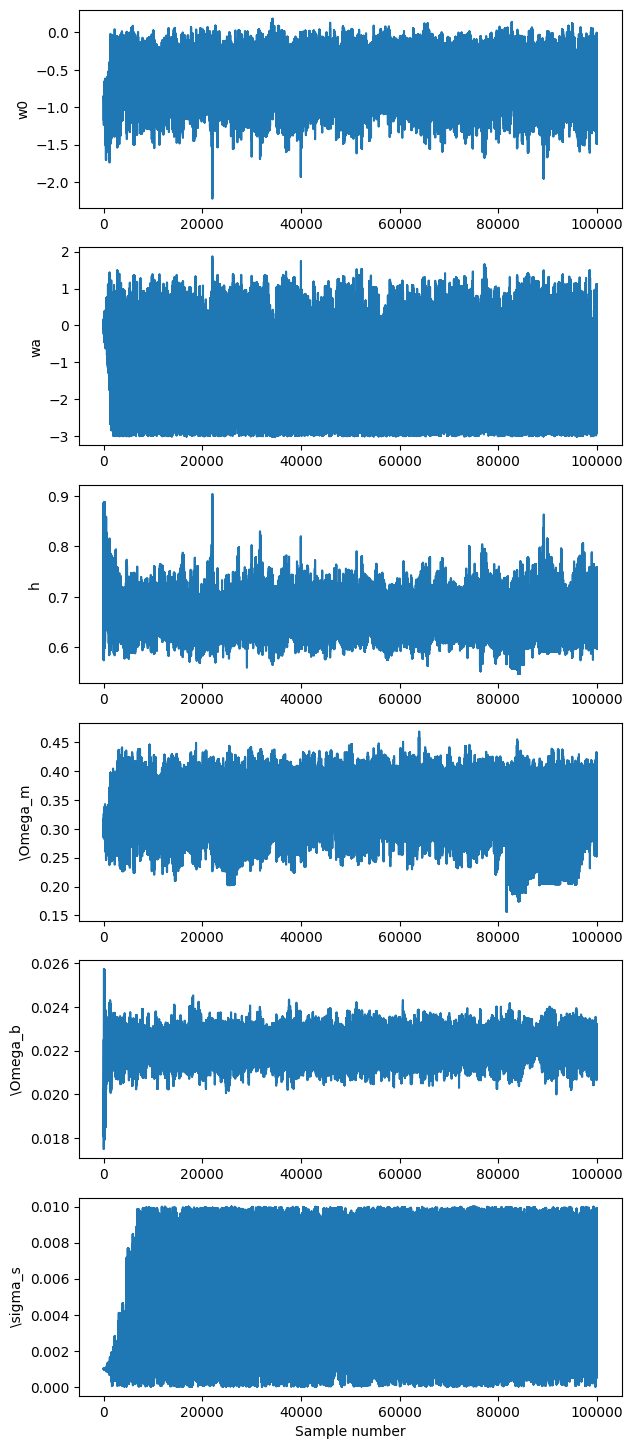

In [28]:
fig, ax = plt.subplots(nrows=6, ncols=1, figsize=(7, 18))  # 创建 1 行 2 列的子图

ax[0].plot(sampler.flatchain[:,0])
ax[0].set_ylabel('w0')  # 设置 y 轴标签

ax[1].plot(sampler.flatchain[:,1])
ax[1].set_ylabel('wa')  # 设置 y 轴标签

ax[2].plot(sampler.flatchain[:,2])
ax[2].set_ylabel('h')  # 设置 y 轴标签

ax[3].plot(sampler.flatchain[:,3])
ax[3].set_ylabel('\Omega_m')  # 设置 y 轴标签

ax[4].plot(sampler.flatchain[:,4])
ax[4].set_ylabel('\Omega_b')  # 设置 y 轴标签

ax[5].plot(sampler.flatchain[:,5])
ax[5].set_ylabel('\sigma_s')  # 设置 y 轴标签
ax[5].set_xlabel('Sample number')  # 设置 x 轴标签

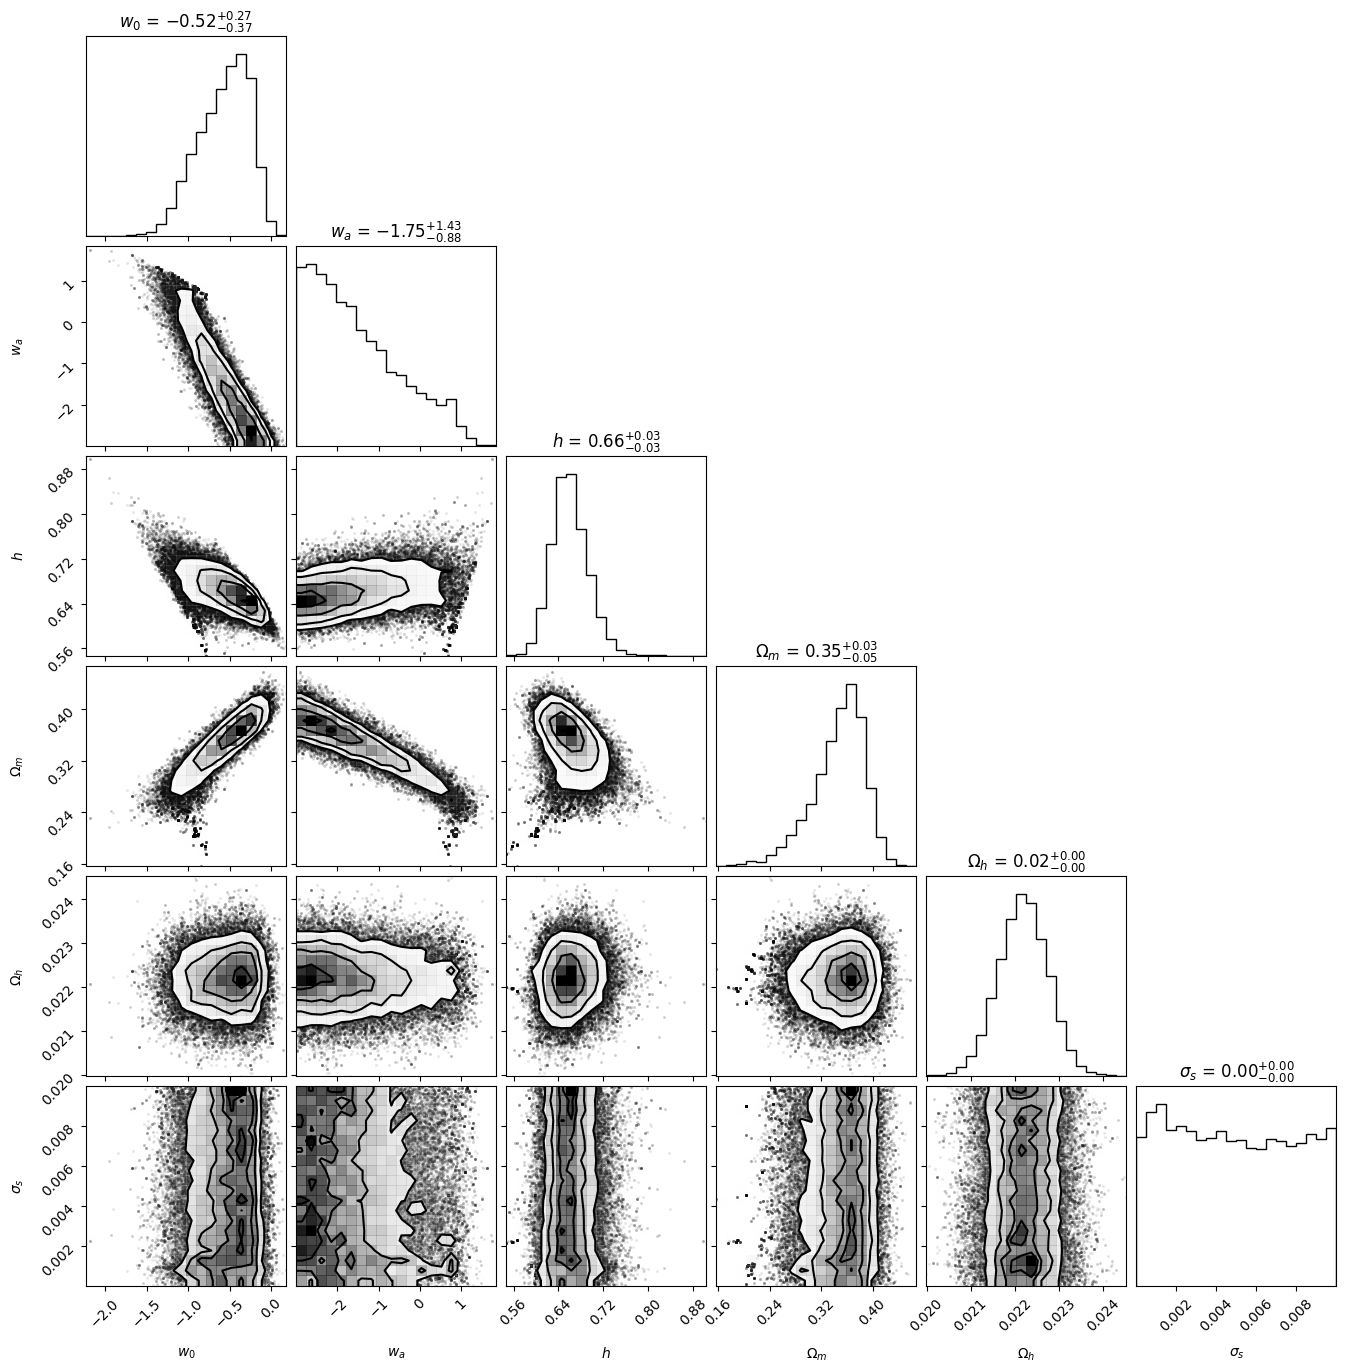

In [29]:
labels = [r"$w_0$", r"$w_a$", r"$h$", r"$\Omega_m$", r"$\Omega_h$", r"$\sigma_s$"]  # LaTeX-style labels
fig = corner.corner(chain,labels=labels, show_titles=True)

In [20]:
chain = np.load('MC_sigmas0_5000.npy')

In [21]:
chain1 = np.load('MC_sigmas_non0_5000.npy')

In [29]:
names = ["x%s"%i for i in range(ndim)]
# labels =  ["x_%s"%i for i in range(ndim)]
labels=["w_0", "w_a", "h", "\Omega_m", "\Omega_b*h^2", "\sigma_s"]
samples = MCSamples(samples=chain,names = names, labels = labels,settings={'smooth_scale_2D':0.3, 'smooth_scale_1D':0.3,'fine_bins_2D':1024},ranges={'x0':[-3,1],'x1':[-3,2],'x2':[0.2,1],'x3':[0.01,0.99],'x4':[0.005,0.1],'x5':[0,1]})
samples1 = MCSamples(samples=chain1,names = names, labels = labels,settings={'smooth_scale_2D':0.3, 'smooth_scale_1D':0.3,'fine_bins_2D':1024},ranges={'x0':[-3,1],'x1':[-3,2],'x2':[0.2,1],'x3':[0.01,0.99],'x4':[0.005,0.1],'x5':[0,1]})
samples2 = MCSamples(samples=chain2,names = names, labels = labels,settings={'smooth_scale_2D':0.3, 'smooth_scale_1D':0.3,'fine_bins_2D':1024},ranges={'x0':[-3,1],'x1':[-3,2],'x2':[0.2,1],'x3':[0.01,0.99],'x4':[0.005,0.1],'x5':[0,10]})

Removed no burn in
Removed no burn in
Removed no burn in


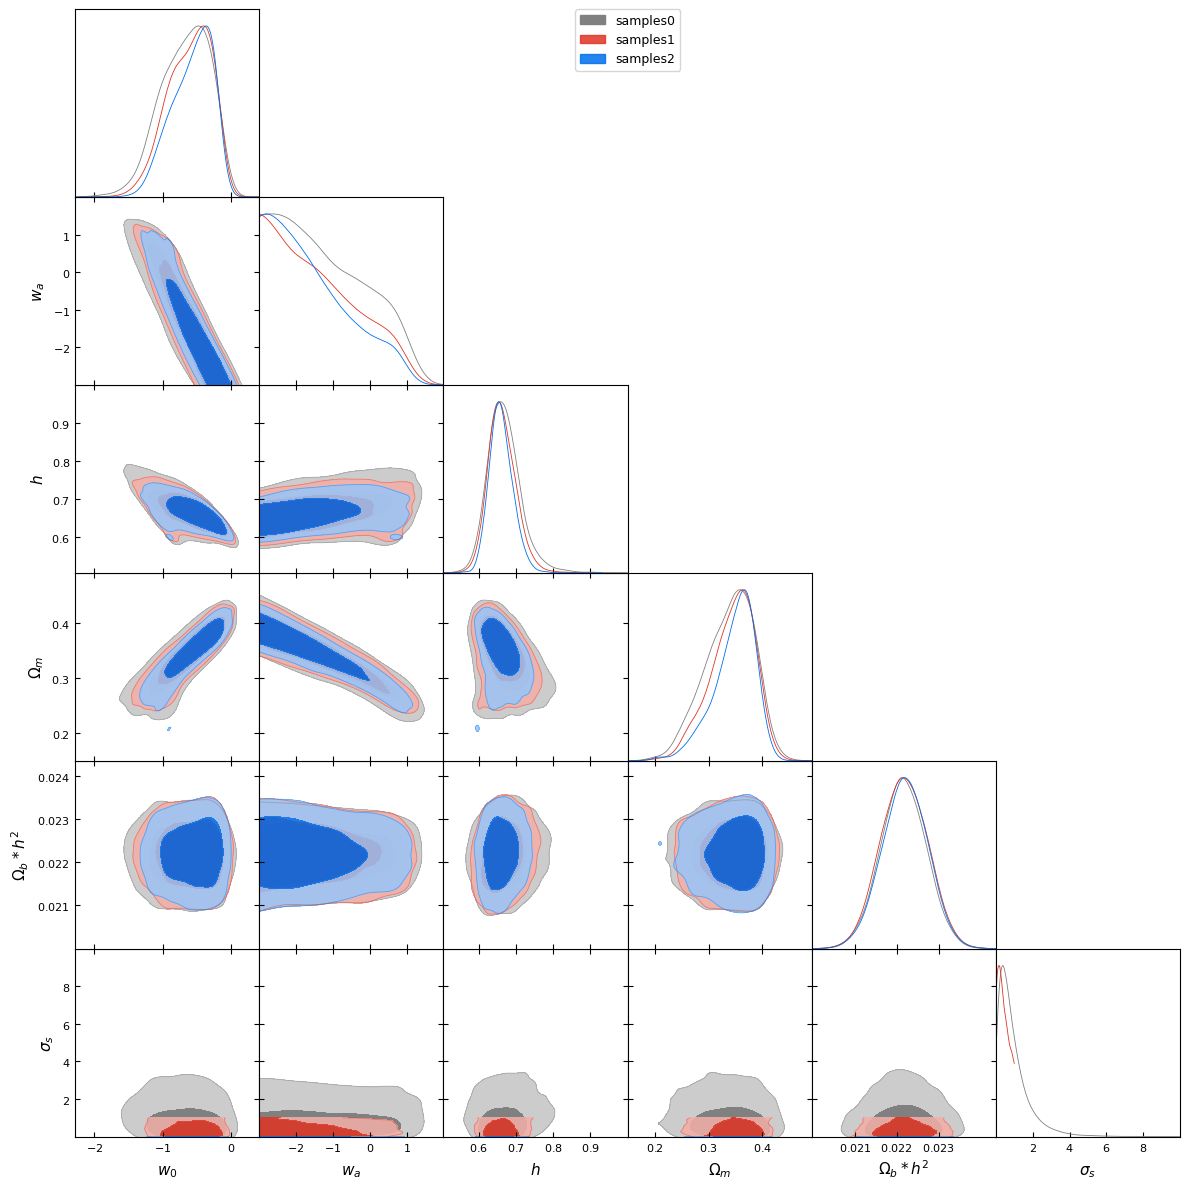

In [30]:
# Triangle plot
g = plots.get_subplot_plotter()
g.triangle_plot([samples2,samples1,samples], filled=True)

In [44]:
print(samples.getMargeStats())

Marginalized limits: 0.68; 0.95; 0.99

parameter   mean           sddev          lower1         upper1         limit1 lower2         upper2         limit2 lower3         upper3         limit3 
x0         -5.6570316E-01  3.0164861E-01 -7.8445152E-01 -1.8143687E-01  two   -1.1610581E+00 -6.7836580E-02  two   -1.3732410E+00 -9.7466886E-03  two     w_0
x1         -1.5322128E+00  1.0688591E+00 -3.0000000E+00 -1.1351705E+00  >     -3.0000000E+00  5.7724482E-01  >     -3.0000000E+00  1.0216797E+00  >       w_a
x2          6.6100703E-01  3.2082444E-02  6.2645474E-01  6.8813999E-01  two    6.0072421E-01  7.2545162E-01  two    5.8836369E-01  7.5624511E-01  two     h
x3          3.4753823E-01  4.0167586E-02  3.2197823E-01  3.9423410E-01  two    2.6332757E-01  4.1574075E-01  two    2.0540771E-01  4.2435482E-01  two     \Omega_m
x4          2.2195968E-02  5.5244106E-04  2.1642236E-02  2.2743535E-02  two    2.1092291E-02  2.3259992E-02  two    2.0748117E-02  2.3586866E-02  two     \Omega_b*h^2
x5   

In [25]:
print(samples1.getMargeStats())

Marginalized limits: 0.68; 0.95; 0.99

parameter   mean           sddev          lower1         upper1         limit1 lower2         upper2         limit2 lower3         upper3         limit3 
x0         -6.0747345E-01  3.2625196E-01 -8.7189966E-01 -2.0871652E-01  two   -1.2364748E+00 -4.5124494E-02  two   -1.4641743E+00  4.7469629E-02  two     w_0
x1         -1.3912419E+00  1.1278015E+00 -3.0000000E+00 -8.9104819E-01  >     -3.0000000E+00  6.9769965E-01  >     -3.0000000E+00  1.1324235E+00  >       w_a
x2          6.6366012E-01  3.8337532E-02  6.2296422E-01  6.9566515E-01  two    5.9156868E-01  7.4084183E-01  two    5.7352892E-01  7.8644522E-01  two     h
x3          3.4379246E-01  4.2541804E-02  3.1196700E-01  3.9392449E-01  two    2.5530213E-01  4.1738573E-01  two    2.1925790E-01  4.3209240E-01  two     \Omega_m
x4          2.2172301E-02  5.6635139E-04  2.1597918E-02  2.2747862E-02  two    2.1071581E-02  2.3266719E-02  two    2.0730652E-02  2.3584332E-02  two     \Omega_b*h^2
x5   

In [33]:
print(samples2.getMargeStats())

Marginalized limits: 0.68; 0.95; 0.99

parameter   mean           sddev          lower1         upper1         limit1 lower2         upper2         limit2 lower3         upper3         limit3 
x0         -6.6601522E-01  3.6528046E-01 -9.6931365E-01 -2.2760911E-01  two   -1.3549544E+00 -2.5492697E-02  two   -1.6408691E+00  9.1935439E-02  two     w_0
x1         -1.2296429E+00  1.1758200E+00 -3.0000000E+00 -6.3543169E-01  >     -3.0000000E+00  8.4959783E-01  >     -3.0000000E+00  1.2593828E+00  >       w_a
x2          6.6950145E-01  4.6761037E-02  6.2146092E-01  7.0455285E-01  two    5.8262542E-01  7.6282348E-01  two    5.6657681E-01  8.4096778E-01  two     h
x3          3.3863042E-01  4.6820955E-02  3.0106309E-01  3.9420479E-01  two    2.4381155E-01  4.2042590E-01  two    2.0714962E-01  4.3814916E-01  two     \Omega_m
x4          2.2155930E-02  5.5178535E-04  2.1610885E-02  2.2705111E-02  two    2.1052395E-02  2.3241266E-02  two    2.0698347E-02  2.3537642E-02  two     \Omega_b*h^2
x5   

In [49]:
samples1 = MCSamples(samples=chain1,names = names, labels = labels,settings={'smooth_scale_2D':0.3, 'smooth_scale_1D':0.3,'fine_bins_2D':1024},ranges={'x0':[-3,1],'x1':[-3,2],'x2':[0.2,1],'x3':[0.01,0.99],'x4':[0.005,0.1],'x5':[0,0.01]})

Removed no burn in


In [ ]:
# Triangle plot
g = plots.get_subplot_plotter()
g.triangle_plot([samples1,samples], filled=True)

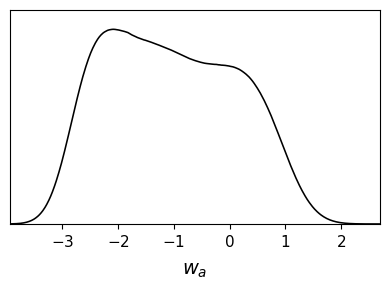

In [95]:
# 1D marginalized plot
g = plots.get_single_plotter(width_inch=4)
g.plot_1d(samples, 'x_1')

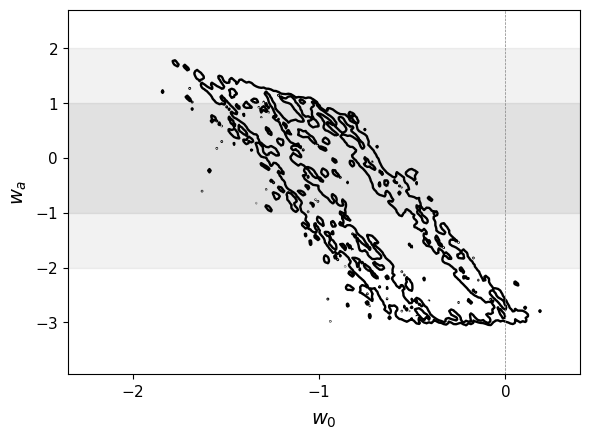

In [99]:
# 2D line contour comparison plot with extra bands and markers
g = plots.get_single_plotter()
g.plot_2d([samples], 'x_0', 'x_1')
g.add_x_marker(0)
g.add_y_bands(0, 1)

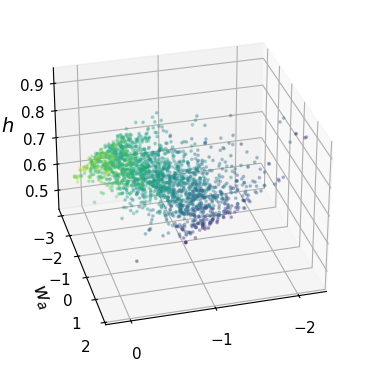

In [100]:
# 4D x-y-z-color scatter plots:
# Use ""%matplotlib notebook" to interactively rotate etc.

g = plots.get_single_plotter()
g.plot_4d([samples], ['x_0', 'x_1', 'x_2', 'x_3'],
          cmap='viridis', color_bar=False, azim=75,
          alpha=[0.3, 0.1],  shadow_color=False, compare_colors=['k'])

Removed no burn in
Removed no burn in


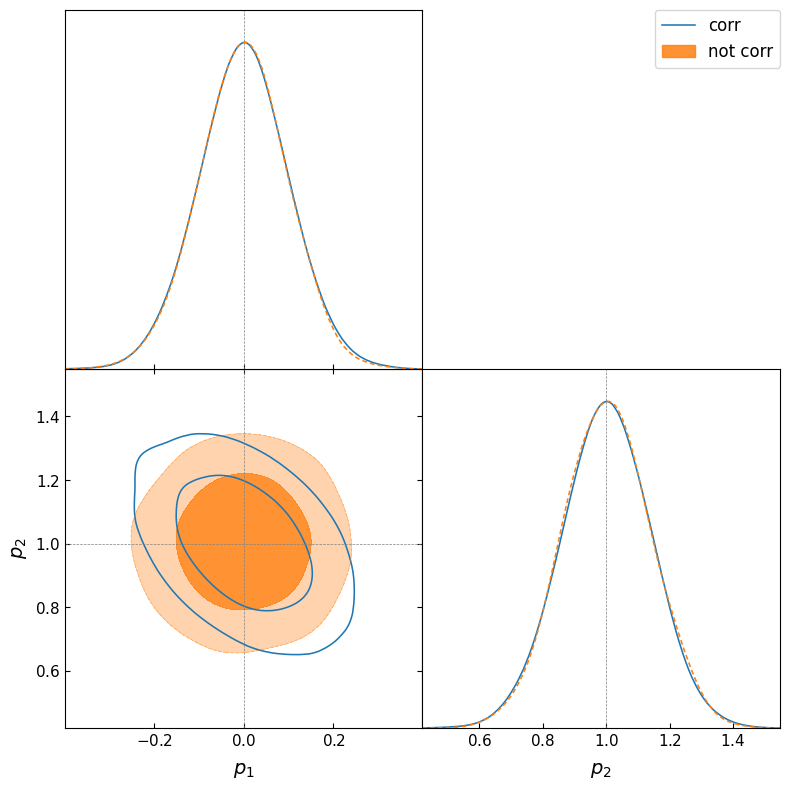

In [101]:
from getdist import MCSamples
from getdist import plots
center=[0,1]
cov_corr=[[0.01, -0.006],[-0.006,0.02]]
cov_notcorr=[[0.01,0],[0,0.02]]
samples_corr = np.random.multivariate_normal(center,cov_corr, size=10000)
samples_notcorr = np.random.multivariate_normal(center,cov_notcorr, size=10000)
samples_corr_gd= MCSamples(samples=samples_corr, 
                      #weights = w, 
                      names =['p1','p2'], 
                      labels = ['p_1','p_2'], 
                      label = 'gaussian', 
                      ranges={'p1':[-1,1],'p2':[0,2]})
samples_notcorr_gd= MCSamples(samples=samples_notcorr, 
                      #weights = w, 
                      names =['p1','p2'], 
                      labels = ['p_1','p_2'], 
                      label = 'gaussian', 
                      ranges={'p1':[-1,1],'p2':[0,2]})
g = plots.get_subplot_plotter(subplot_size=4)
g.triangle_plot([samples_corr_gd,samples_notcorr_gd], #chains you want to plot
                ['p1','p2'],#parameters of interest
                filled=[False,True],#filling the contour with color or not
                legend_labels=['corr', 'not corr'],#labels for chains
                contour_colors=['C0','C1'],#colors
                contour_ls=['-','--'],#line style
                markers={'p1':0,'p2':1},#if you want to add markers to the contour
                )